In [18]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# #Install Apache Spark 3.2.1 with Hadoop 3.2, get zipped folder
!wget -q https://dlcdn.apache.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz    

# #Unzip folder
!tar xf spark-3.3.1-bin-hadoop3.tgz

# #Install findspark, pyspark 3.2.1
!pip install -q findspark
!pip install pyspark==3.2.1

# #Set variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.1-bin-hadoop3"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [19]:
pip install elasticsearch==7.17.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
import sys
import pandas as pd
import seaborn as sns
from time import time
from pyspark.sql import Row
from pyspark.sql import SparkSession
from pyspark.sql.types import DoubleType
import matplotlib.pyplot as plt
from pyspark.ml.feature import StringIndexer
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit,CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml import Pipeline, PipelineModel

%matplotlib inline

In [21]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext.getOrCreate();
spark = SparkSession(sc)
spark.conf.set("spark.sql.caseSensitive", "true")
spark

In [22]:
#start the engine first

# test your ES instance is running
from elasticsearch import Elasticsearch

es = Elasticsearch(
    ['s-for-ds.es.us-central1.gcp.cloud.es.io'],
    http_auth=('elastic', 'yRG2A89HY5IbVuBinEtu8F8x!'),
    scheme="https",
    port=9243
)



In [23]:
multiline_df = spark.read.json("/content/digitalMusic 5.txt")

multiline_df = multiline_df.withColumn("overall", multiline_df["overall"].cast(DoubleType()))
multiline_df = multiline_df.drop('reviewerName','verified')

multiline_df.printSchema()
multiline_df = multiline_df.where(multiline_df.overall.isNotNull()).persist()
reviews_df = multiline_df.selectExpr("asin","overall as rating", "reviewerID as reviewer")
reviews_df.show()




root
 |-- _id: string (nullable = true)
 |-- asin: string (nullable = true)
 |-- overall: double (nullable = true)
 |-- reviewerID: string (nullable = true)

+----------+------+--------------+
|      asin|rating|      reviewer|
+----------+------+--------------+
|0001393774|   5.0|A171I27YBM4FL6|
|0001393774|   5.0|A1H1DL4K669VQ9|
|0001393774|   5.0|A23WIHT5886G36|
|0001393774|   5.0|A3SZNOJP8OL26X|
|0001393774|   5.0|A3V5XBBT7OZG5G|
|0001393774|   5.0|A3SNL7UJY7GWBI|
|0001393774|   5.0|A3478QRKQDOPQ2|
|0001393774|   4.0|A3CP0CNKNFCYBZ|
|0001393774|   5.0|A3OIIDZ137NJOU|
|0001393774|   4.0|A3GVAG32NMMYT4|
|0001393774|   5.0|A3232ASBJ7KC62|
|0001393774|   5.0|A1YFNAB3OI9PVF|
|0001393774|   5.0|A2DHT9Y9D27CEU|
|0001393774|   5.0|A2W6V65OFOZ12M|
|0001393774|   5.0|A1HQAUBL5BDZH9|
|0001393774|   5.0|A23M5VTSN2C3H1|
|0001393774|   5.0|A1DOF5GHOWGMW6|
|0001393774|   5.0|A1TTHKFXLZ28ON|
|0001393774|   5.0|A1CQY90X082Z0W|
|0001393774|   5.0| AYU1GV7AIQ5YY|
+----------+------+--------------+
on

In [24]:
rows = reviews_df.count()
print(rows)

99999


In [25]:
# transform asin and reviewer alphanumeric string to index using spark StringIndexer function
asinIndexer = StringIndexer(inputCol="asin", outputCol="item",handleInvalid='error') # create indexer for asins
reviewerIndexer = StringIndexer(inputCol='reviewer',outputCol='reviewerid',handleInvalid='error') # create indexer for reviewer
asinIndexed = asinIndexer.fit(reviews_df).transform(reviews_df) # apply asin indexer
reviewerIndexer = reviewerIndexer.fit(asinIndexed).transform(asinIndexed) # apply reviewer indexer
indexedDataFrame = reviewerIndexer.drop('asin').drop('reviewer') # remove old columns with alphanumeric strings

# 80-20 train-test split
(df_train, df_test) = indexedDataFrame.randomSplit([0.8,0.2])

# cache them in memory across clusters since we access this data frequently 
df_train.cache() 
df_test.cache()

# Display dataset size
print('Train set size: {}'.format(df_train.count()))
print('Test set size: {}'.format(df_test.count()))

print('Matrix size, percentage of matrix filled and number of distinct reviewers and itmes:')
# calculate percentage of the reviewer-item matrix that is filled
df_train.createOrReplaceTempView('df_train')
spark.sql("""
      SELECT *, 100 * rating/matrix_size AS percentage
        FROM (
          SELECT reviewerid, item, rating, reviewerid * item AS matrix_size
            FROM(
              SELECT COUNT(*) AS rating, COUNT(DISTINCT(item)) AS item, COUNT(DISTINCT(reviewerid)) AS reviewerid
                FROM df_train
                )
            )
""").show()

Train set size: 79981
Test set size: 20018
Matrix size, percentage of matrix filled and number of distinct reviewers and itmes:
+----------+----+------+-----------+--------------------+
|reviewerid|item|rating|matrix_size|          percentage|
+----------+----+------+-----------+--------------------+
|     63172|2831| 79981|  178839932|0.044722114969267604|
+----------+----+------+-----------+--------------------+



In [26]:
dataVisualization = indexedDataFrame.sample(False,0.09) # sample a small portion of the dataset for visualization
dataFrame = dataVisualization.toPandas() # convert to pandas dataframe

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


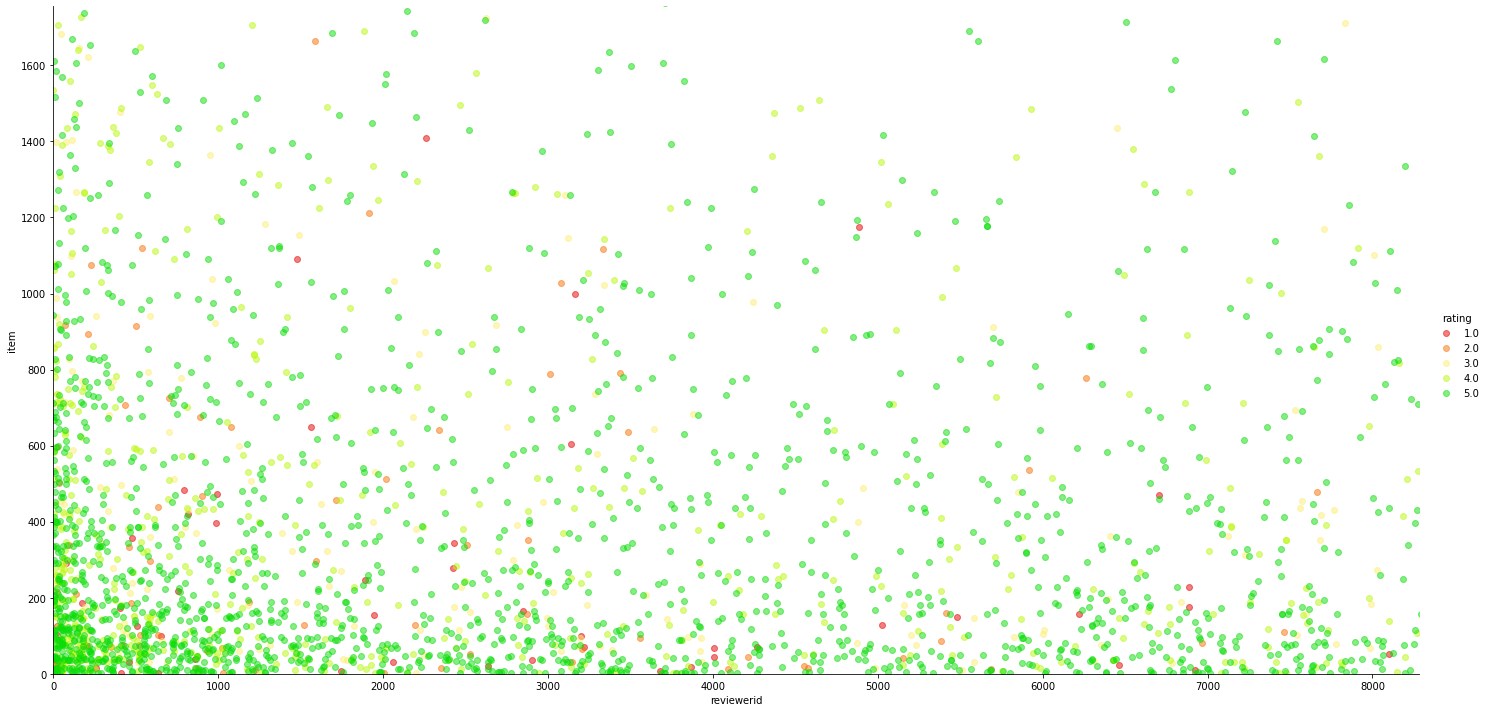

In [27]:

numuniqreviewer = dataFrame['reviewerid'].value_counts().count() # to set axis
numuniqitem = dataFrame['item'].value_counts().count() # to set axis

custompal = sns.xkcd_palette(['red', 'orange', 'sandy yellow', 'yellowgreen', 'vibrant green']) # traffic-light style palette
scatterplot = sns.lmplot('reviewerid','item',dataFrame,hue='rating',fit_reg=False,size=10 # use seaborn lmplot to plot reviewer vs item and rating as hue
           , aspect=2,palette=custompal,scatter_kws={'alpha':0.5})

axes = scatterplot.axes
axes[0,0].set_ylim(0,numuniqitem)  
axes[0,0].set_xlim(0,numuniqreviewer) 
scatterplot
plt.savefig('scatterplot.png',dpi=50)

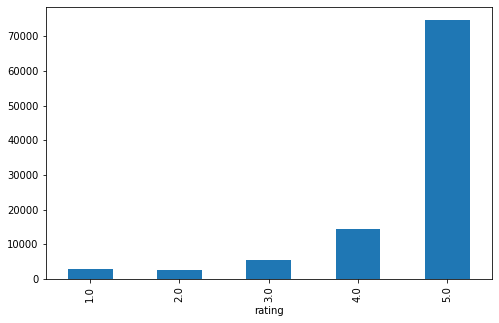

In [28]:
indexedDataFrame.createOrReplaceTempView('indexDF') 

ratingcount = spark.sql("""
      SELECT COUNT(rating) as count
      ,rating
      FROM indexDF
      GROUP BY rating
""")
pandas_rc = ratingcount.toPandas()  # convert to pandas
pandas_rc.sort_values('rating',axis=0,inplace=True) # sort 
pandas_rc.plot(x='rating',y='count',kind='bar',legend=False,figsize=(8,5)) # plot using the traffic-light palette
plt.savefig('barchart.png',dpi=70) # save to disk
plt.show()

In [29]:
pandas_rc

,count,rating
0,2992,1.0
3,2463,2.0
2,5431,3.0
1,14444,4.0
4,74669,5.0


In [30]:
mean = float(df_train.describe().toPandas()['rating'][1]) # mean
print('Training set mean: {}'.format(mean))
print('Test set baseline MSE and RMSE')     
se_rdd = df_test.rdd.map(lambda x: (x[0]-mean)**2) #  squared error
row = Row("val") # create row
se_df = se_rdd.map(row).toDF() # convert to df
se_df.createOrReplaceTempView('tempDF') # create temp SQL view
baseline = spark.sql('SELECT AVG(val) as MSE,SQRT(AVG(val)) as RMSE  FROM tempDF') # calculate MSE and RMSE
baseline.show()
baseline_rmse = float(baseline.toPandas()['RMSE'][0]) 


Training set mean: 4.555731986346757
Test set baseline MSE and RMSE
+------------------+------------------+
|               MSE|              RMSE|
+------------------+------------------+
|0.8884354162763074|0.9425685207327409|
+------------------+------------------+



ALS

Define Pipeline

In [31]:
# define overall pipeline 

def als_pipeline(df_train,df_test,trainingdownsampling=0.99):
    """
      Args: 
        df_train: pyspark train dataframe  
        df_test: pyspark test dataframe
        trainingdownsampling: percentage of full training set
      Returns:
        testset_rmse
        baseline_rmse
        wallclock
    """

    # model
    als = ALS(userCol="reviewerid", itemCol="item", ratingCol="rating",coldStartStrategy='drop',nonnegative=False)
    
    # evaluator
    rmseevaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

    # parameter grid
    paramGrid = ParamGridBuilder()\
        .addGrid(als.rank, [1, 5, 10,50,70]) \
        .addGrid(als.maxIter, [15])\
        .addGrid(als.regParam, [0.05, 0.1, 0.5,5])\
        .build()

    # train validation split
    tvs = TrainValidationSplit(estimator=als,
                               estimatorParamMaps=paramGrid,
                               evaluator=rmseevaluator,
                               trainRatio=0.8)

    
    # sample, Note : spark sample does is not guaranteed to provide exactly the fraction specified of the total
    training = df_train.sample(False,trainingdownsampling)
    print('Full training set size: {}'.format(df_train.count()))
    print('Downsampled training set size: {} \n'.format(training.count()))
  
    # fit model and time it
    print('Fitting model...')
    startTime = time()
    tvsmodel = tvs.fit(training)
    endTime = time()
    wallclock = ( endTime - startTime )
    
    print('Wall-clock time: {}'.format(wallclock))
    
    print('\n')
    paramMap = list(zip(tvsmodel.validationMetrics,tvsmodel.getEstimatorParamMaps())) # zip validation rmse and selected parameters
    paramMax = min(paramMap)
    print('Best parameters and validation set RMSE:')
    print(paramMax)
    print('\n')
    
    # predict and evaluate test set
    predictions = tvsmodel.transform(df_test)
    testset_rmse = rmseevaluator.evaluate(predictions)
    print('Test set RMSE: {}'.format(testset_rmse))    
    return testset_rmse,wallclock,paramMax

ALS on downsampled training sets



In [32]:
downsamples = [0.01,0.1,0.5,0.8] # list of percentages to downsample training set
rmses = [] 
wallclocks = []
params = []
# loop through the list and apply the pipeline function, append the results to the above empty lists
for s in downsamples:
    #print('Fitting als model for {} % of the training set'.format(s*100))
    test_rmse,wallclock,parammax = als_pipeline(df_train,df_train,trainingdownsampling=s)
    rmses.append(test_rmse)
    wallclocks.append(wallclock)
    params.append(parammax)

Full training set size: 79981
Downsampled training set size: 822 

Fitting model...
Wall-clock time: 1010.6640281677246


Best parameters and validation set RMSE:
(0.023438453674316406, {Param(parent='ALS_6b7a7707d4ad', name='rank', doc='rank of the factorization'): 1, Param(parent='ALS_6b7a7707d4ad', name='maxIter', doc='max number of iterations (>= 0).'): 15, Param(parent='ALS_6b7a7707d4ad', name='regParam', doc='regularization parameter (>= 0).'): 0.05})


Test set RMSE: 5.258200918552128
Full training set size: 79981
Downsampled training set size: 8052 

Fitting model...
Wall-clock time: 490.8967475891113


Best parameters and validation set RMSE:
(4.3201233520571085, {Param(parent='ALS_ea47da141b58', name='rank', doc='rank of the factorization'): 10, Param(parent='ALS_ea47da141b58', name='maxIter', doc='max number of iterations (>= 0).'): 15, Param(parent='ALS_ea47da141b58', name='regParam', doc='regularization parameter (>= 0).'): 0.5})


Test set RMSE: 3.0857316724930635
Full tr

ALS executed on the full training set

In [33]:

# model
als = ALS(userCol="reviewerid", itemCol="item", ratingCol="rating",coldStartStrategy='drop',nonnegative=False)
     
# evaluator
rmseevaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

# parameter grid
paramGrid = ParamGridBuilder()\
    .addGrid(als.rank, [1, 5, 10,50,70]) \
    .addGrid(als.maxIter, [15])\
    .addGrid(als.regParam, [0.05, 0.1, 0.5,5])\
    .build()

# train validation split
tvs = TrainValidationSplit(estimator=als,
                           estimatorParamMaps=paramGrid,
                           evaluator=rmseevaluator,
                           trainRatio=0.8)
# fit model and time
startTime = time()
tvsmodel = tvs.fit(df_train)
endTime = time()
wallclock = ( endTime - startTime )
    
print('Wall-clock time: {}'.format(wallclock))
    
print('\n')
# zip train validation and parameter into one list
paramMap = list(zip(tvsmodel.validationMetrics,tvsmodel.getEstimatorParamMaps()))
paramMax = min(paramMap)
print(paramMax)

# predict and evaluate test set
predictions = tvsmodel.transform(df_test)
testset_rmse = rmseevaluator.evaluate(predictions)
print('Test set RMSE: {}'.format(testset_rmse))    
    

Wall-clock time: 1449.1502923965454


(1.7103052277180189, {Param(parent='ALS_91638777764b', name='rank', doc='rank of the factorization'): 50, Param(parent='ALS_91638777764b', name='maxIter', doc='max number of iterations (>= 0).'): 15, Param(parent='ALS_91638777764b', name='regParam', doc='regularization parameter (>= 0).'): 0.5})
Test set RMSE: 1.556624521471887


Results

In [34]:

# append with full train set
rmses.append(testset_rmse)
wallclocks.append(wallclock)
params.append(paramMax)

In [35]:
# getting terms separately since dictionaries are only ordered in Python 3.6 onwards, we are still on Python 3.5
rank1 = list(params[0][1].values())[0]
iter1 = list(params[0][1].values())[1]
reg1 = list(params[0][1].values())[2]

rank2 = list(params[1][1].values())[1]
iter2 = list(params[1][1].values())[2]
reg2 = list(params[1][1].values())[0]

rank3 = list(params[2][1].values())[0]
iter3 = list(params[2][1].values())[2]
reg3 = list(params[2][1].values())[1]

rank4 = list(params[3][1].values())[1]
iter4 = list(params[3][1].values())[0]
reg4 = list(params[3][1].values())[2]

rank5 = list(params[4][1].values())[0]
iter5 = list(params[4][1].values())[1]
reg5 = list(params[4][1].values())[2]

In [38]:

# convert to lists
val_rmse = list(map(lambda x: x[0], params))
ranks = [rank1,rank2,rank3,rank4,rank5]
iters = [iter1,iter2,iter3,iter4,iter5]
regParams = [reg1,reg2,reg3,reg4,reg5]
downsamples.append(1)


In [39]:
pd_results = pd.DataFrame(
    {'Downsample percentage': downsamples,
     'Number of latent factors': ranks,
     'Maximum number of iterations': iters,
     'Regularization parameter': regParams,
     'Wall-clock time': wallclocks,
     'Validation RMSE': val_rmse,
     'Test RMSE': rmses
    })

In [40]:
# display dataframe
pd_results

,Downsample percentage,Number of latent factors,Maximum number of iterations,Regularization parameter,Wall-clock time,Validation RMSE,Test RMSE
0,0.01,1,15.0,0.05,1010.664028,0.023438,5.258201
1,0.10,15,0.5,10.00,490.896748,4.320123,3.085732
2,0.50,50,0.5,15.00,953.592649,2.418005,1.041042
3,0.80,15,50.0,0.50,1253.264282,1.901110,0.689449
4,1.00,50,15.0,0.50,1449.150292,1.710305,1.556625


In [41]:
# save to disk
pd_results.to_csv('results.csv')

In [45]:
from pyspark.sql.functions import lit
from pyspark.ml.feature import IndexToString

def recommendProducts(model, reviewer, num_rec):
    # Create a dataset with distinct games as one column and the reviewer of interest as another column
    itemsreviewer = df_train.select("item").distinct().withColumn("reviewerid", lit(reviewer))
    #itemsreviewer.show(n=5)

    # filter out games that reviewer has already rated 
    ratedProducts = df_train.filter(df_train.reviewerid == reviewer).select("item", "reviewerid")

    # apply trained recommender system
    predictions = model.transform(itemsreviewer.subtract(ratedProducts)).dropna().orderBy("prediction", ascending=False).limit(num_rec).select("item", "prediction")
    predictions.show()
    
    # convert index back to original ASIN 
    converter = IndexToString(inputCol="item", outputCol="originalCategory")
    converted = converter.transform(predictions)
    converted.show()

In [46]:
df_train.show(n=5)

+------+----+----------+
|rating|item|reviewerid|
+------+----+----------+
|   1.0| 0.0|   15137.0|
|   1.0| 0.0|   16464.0|
|   1.0| 0.0|   16660.0|
|   1.0| 0.0|   19771.0|
|   1.0| 0.0|   23607.0|
+------+----+----------+
only showing top 5 rows



In [44]:
# pick a random reviewer id (30) and display 5 recommendations
recommendProducts(tvsmodel,100,5)

+------+----------+
|  item|prediction|
+------+----------+
|2415.0|  4.488339|
|1706.0| 4.4698334|
|1746.0| 4.4519434|
|1908.0|  4.447718|
|1444.0| 4.4415245|
+------+----------+

+------+----------+----------------+
|  item|prediction|originalCategory|
+------+----------+----------------+
|2415.0|  4.488339|      B000001F3F|
|1706.0| 4.4698334|      B000001AIW|
|1746.0| 4.4519434|      B0000005O7|
|1908.0|  4.447718|      B00000179Z|
|1444.0| 4.4415245|      B000001E9K|
+------+----------+----------------+



Displaying Recommendations: 

https://www.amazon.com/gp/product/B000000NGB/r

https://www.amazon.com/Island-Years-John-Cale/dp/B000001E9K

https://www.amazon.com/Sea-Sky-STOMU-YAMASHTA/dp/B0000018WV
